In [9]:
!pip install seaborn cornac tensorflow

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached tqdm-4.67.0-py3-none-any.whl.metadata (57 kB)
  Using cached powerlaw-1.5-py3-none-any.whl.metadata (9.3 kB)
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-4.25.5-cp37-abi3-macosx_10_9_universal2.whl.metadata (541 bytes)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using c

In [10]:
import os
import sys
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cornac
from cornac.utils import cache
from cornac.datasets import filmtrust, amazon_clothing
from cornac.eval_methods import RatioSplit
from cornac.models import PMF, SoRec, WMF, CTR, BPR, VBPR
from cornac.data import GraphModality, TextModality, ImageModality
from cornac.data.text import BaseTokenizer

import tensorflow as tf
print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")
print(f"Tensorflow version: {tf.__version__}")

SEED = 1234
VERBOSE = True

/Users/kimminsu/miniconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


System version: 3.8.20 (default, Oct  3 2024, 10:22:23) 
[Clang 14.0.6 ]
Cornac version: 2.2.2
Tensorflow version: 2.13.0


## 1. Feature Modality

In [2]:
# user_features, item_features = pd.read_pickle('features.pkl')

# from cornac.data import FeatureModality

# # FeatureModality를 사용하여 사용자와 아이템의 feature를 정의합니다.
# user_feature_modality = FeatureModality(features=user_features, ids=None, normalize=False)
# item_feature_modality = FeatureModality(features=item_features, ids=None, normalize=False)

# # 평가방법 설정
# eval_method = BaseMethod.from_splits(
#     train_data=np.array(train), 
#     test_data=np.array(test), 
#     user_features=user_feature_modality, item_features=item_feature_modality,
#     exclude_unknowns=True,  # Unknown users and items will be ignored.
#     verbose=True
# )

# 2. GraphModality

## Social Recommendation (SoRec)


- SoRec 아키텍쳐
<img src='image/SoRec.png' align="left" width=800/>

In [11]:
K = 20
sorec = SoRec(k=K, max_iter=50, learning_rate=0.001, verbose=VERBOSE, seed=SEED)
pmf = PMF(k=K, max_iter=50, learning_rate=0.001, lambda_reg=0.01, verbose=VERBOSE, seed=SEED)

ratings = filmtrust.load_feedback()
trust = filmtrust.load_trust()

user_graph_modality = GraphModality(data=trust)

ratio_split = RatioSplit(
    data=ratings,
    test_size=0.2,
    rating_threshold=2.5,
    exclude_unknowns=True,
    user_graph=user_graph_modality,
    verbose=VERBOSE,
    seed=SEED,
)

mae = cornac.metrics.MAE()

cornac.Experiment(eval_method=ratio_split, models=[sorec, pmf], metrics=[mae]).run()

Data from https://static.preferred.ai/cornac/datasets/filmtrust/filmtrust.zip
will be cached into /Users/kimminsu/.cornac/filmtrust/ratings.txt


106kB [00:00, 455kB/s]                              
/Users/kimminsu/miniconda3/envs/myenv/lib/python3.8/site-packages/cornac/data/dataset.py:335: UserWarning: 1 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


Unzipping ...
File cached!
rating_threshold = 2.5
exclude_unknowns = True
---
Training data:
Number of users = 1475
Number of items = 1917
Number of ratings = 28396
Max rating = 4.0
Min rating = 0.5
Global mean = 3.0
---
Test data:
Number of users = 1475
Number of items = 1917
Number of ratings = 6873
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 1475
Total items = 1917

[SoRec] Training started!
Learning...
epoch 0, loss: 3336.866073
epoch 1, loss: 2928.795649
epoch 2, loss: 2463.184595
epoch 3, loss: 2220.541953
epoch 4, loss: 2110.565760
epoch 5, loss: 2044.658160
epoch 6, loss: 1995.125000
epoch 7, loss: 1954.012938
epoch 8, loss: 1918.281104
epoch 9, loss: 1886.355976
epoch 10, loss: 1857.334871
epoch 11, loss: 1830.593392
epoch 12, loss: 1805.751273
epoch 13, loss: 1782.438519
epoch 14, loss: 1760.579884
epoch 15, loss: 1739.915589
epoch 16, loss: 1720.301302
epoch 17, loss: 1701.677061
epoch 18, loss: 1683.843279
epoch 19, loss: 1666.720036
epoch 20, 

Rating: 100%|██████████| 6873/6873 [00:00<00:00, 196865.79it/s]


[PMF] Training started!


Learning...
epoch 0, loss: 3260.518425
epoch 1, loss: 3123.428723
epoch 2, loss: 2936.524485
epoch 3, loss: 2778.610802
epoch 4, loss: 2658.799484
epoch 5, loss: 2567.284771
epoch 6, loss: 2495.441571
epoch 7, loss: 2437.683320
epoch 8, loss: 2390.344491
epoch 9, loss: 2350.879752
epoch 10, loss: 2317.429363
epoch 11, loss: 2288.622307
epoch 12, loss: 2263.486231
epoch 13, loss: 2241.328288
epoch 14, loss: 2221.630328
epoch 15, loss: 2203.990717
epoch 16, loss: 2188.092781
epoch 17, loss: 2173.683612
epoch 18, loss: 2160.558220
epoch 19, loss: 2148.548212
epoch 20, loss: 2137.513659
epoch 21, loss: 2127.337084
epoch 22, loss: 2117.919045
epoch 23, loss: 2109.174712
epoch 24, loss: 2101.031310
epoch 25, loss: 2093.426001
epoch 26, loss: 2086.304263
epoch 27, loss: 2079.618584
epoch 28, loss: 2073.327367
epoch 29, loss: 2067.394102
epoch 30, loss: 2061.786625
epoch 31, loss: 2056.476524
epoch 32, loss: 2051.438639
epoch 33, loss: 2046.650630
epoch 34, loss: 2042.092605
epoch 35, loss: 20

Rating: 100%|██████████| 6873/6873 [00:00<00:00, 155623.85it/s]


TEST:
...
      |    MAE | Train (s) | Test (s)
----- + ------ + --------- + --------
SoRec | 0.6470 |    0.8294 |   0.0793
PMF   | 0.6862 |    0.5972 |   0.0873



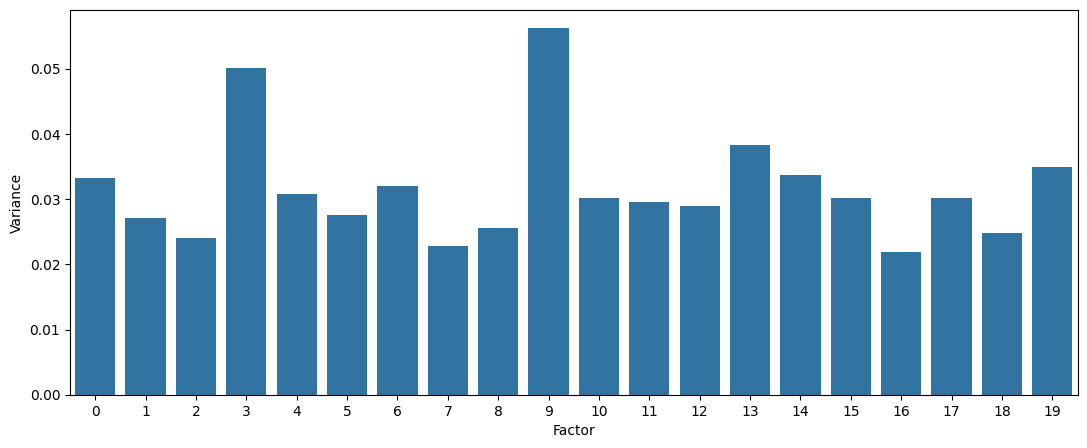

In [12]:
var_df = pd.DataFrame({"Factor": np.arange(K), "Variance": np.var(sorec.U, axis=0)})
fig, ax = plt.subplots(figsize=(13, 5))
sns.barplot(x="Factor", y="Variance", data=var_df, ax=ax);

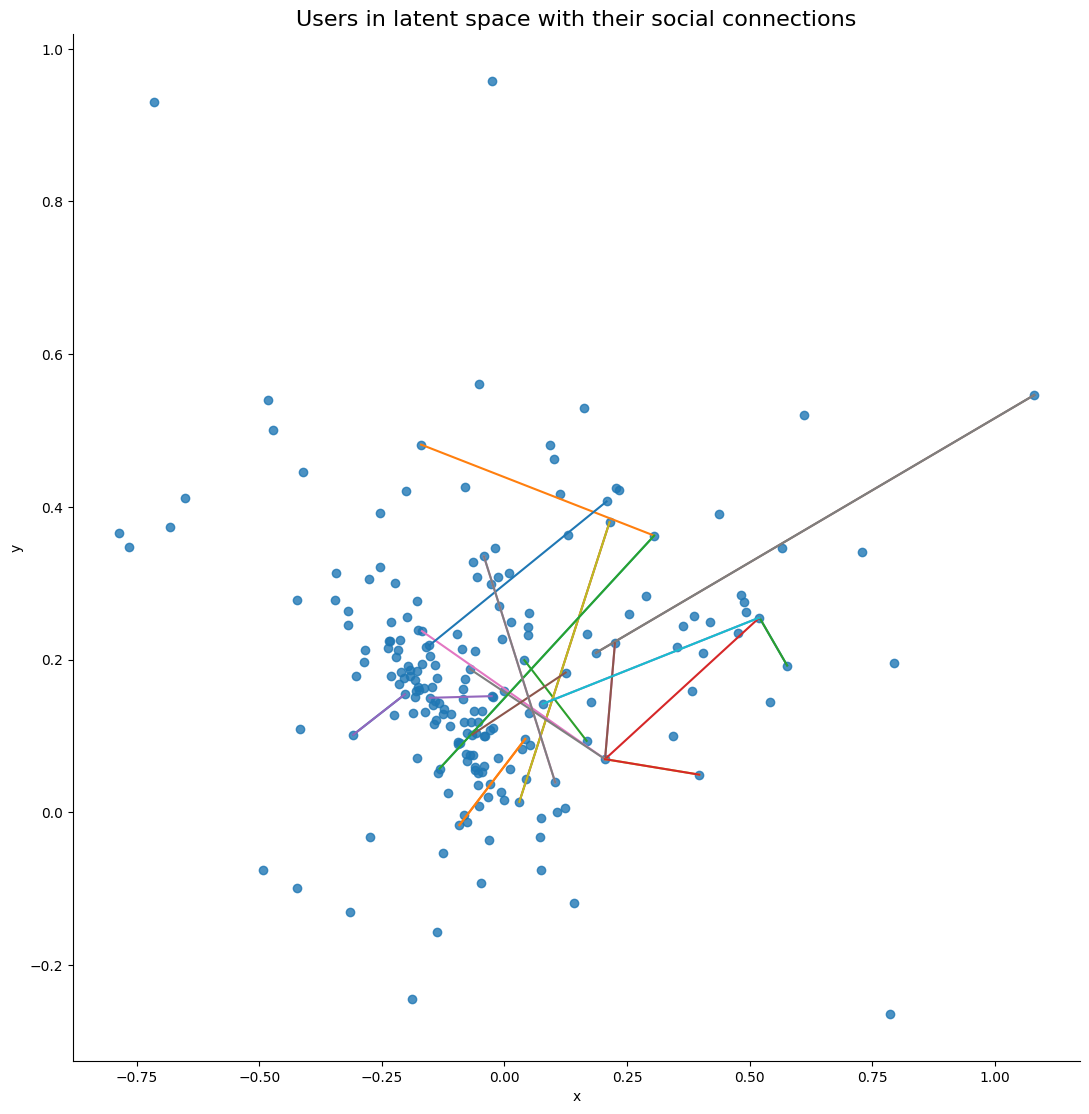

In [13]:
TOP2F = (9, 16)
SAMPLE_SIZE = 200

rng = np.random.RandomState(SEED)
sample_inds = rng.choice(np.arange(sorec.U.shape[0]), size=SAMPLE_SIZE, replace=False)
sample_df = pd.DataFrame(data=sorec.U[sample_inds][:, TOP2F], columns=["x", "y"])
g = sns.lmplot(x="x", y="y", data=sample_df, height=11.0, fit_reg=False)
g.ax.set_title("Users in latent space with their social connections", fontsize=16)

adj_mat = sorec.train_set.user_graph.matrix
for i in range(len(sample_inds)):
  for j in range(len(sample_inds)):
    if j != i and adj_mat[sample_inds[i], sample_inds[j]]:
      sns.lineplot(x="x", y="y", data=sample_df.loc[[i, j]])

# 3. TextModality

## Collaborative Topic Regression (CTR)

- CTR 아키텍쳐
<img src='image/CTR.png' align="left" width=800/>

In [14]:
K = 20
ctr = CTR(k=K, max_iter=50, a=1.0, b=0.01, lambda_u=0.01, lambda_v=0.01, verbose=VERBOSE, seed=SEED)
wmf = WMF(k=K, max_iter=50, a=1.0, b=0.01, learning_rate=0.005, lambda_u=0.01, lambda_v=0.01, 
          verbose=VERBOSE, seed=SEED)

ratings = amazon_clothing.load_feedback()
docs, item_ids = amazon_clothing.load_text()

item_text_modality = TextModality(
    corpus=docs,
    ids=item_ids,
    tokenizer=BaseTokenizer(sep=" ", stop_words="english"),
    max_vocab=8000,
    max_doc_freq=0.5,
)

ratio_split = RatioSplit(
    data=ratings,
    test_size=0.2,
    rating_threshold=4.0,
    exclude_unknowns=True,
    item_text=item_text_modality,
    verbose=VERBOSE,
    seed=SEED,
)

rec_50 = cornac.metrics.Recall(50)

cornac.Experiment(eval_method=ratio_split, models=[ctr, wmf], metrics=[rec_50]).run()

Data from https://static.preferred.ai/cornac/datasets/amazon_clothing/rating.zip
will be cached into /Users/kimminsu/.cornac/amazon_clothing/rating.txt


164kB [00:00, 783kB/s]                             


Unzipping ...
File cached!
Data from https://static.preferred.ai/cornac/datasets/amazon_clothing/text.zip
will be cached into /Users/kimminsu/.cornac/amazon_clothing/text.txt


475kB [00:00, 1.59MB/s]                            


Unzipping ...
File cached!
rating_threshold = 4.0
exclude_unknowns = True
---
Training data:
Number of users = 5066
Number of items = 3333
Number of ratings = 10951
Max rating = 5.0
Min rating = 1.0
Global mean = 4.4
---
Test data:
Number of users = 5066
Number of items = 3333
Number of ratings = 2192
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 5066
Total items = 3333

[CTR] Training started!


100%|██████████| 50/50 [00:49<00:00,  1.01it/s, cf_loss=4.09e+4, lda_likelihood=-1.08e+5]


Learning completed!

[CTR] Evaluation started!


Ranking: 100%|██████████| 1823/1823 [00:00<00:00, 3660.49it/s]



[WMF] Training started!


100%|██████████| 50/50 [00:06<00:00,  8.20it/s, loss=26.3]


Learning completed!

[WMF] Evaluation started!


Ranking: 100%|██████████| 1823/1823 [00:00<00:00, 3205.07it/s]


TEST:
...
    | Recall@50 | Train (s) | Test (s)
--- + --------- + --------- + --------
CTR |    0.2297 |   49.6122 |   0.5001
WMF |    0.1720 |    6.2956 |   0.5709



In [15]:
vocab = ctr.train_set.item_text.vocab
topic_word_dist = ctr.model.beta.T[:, -ctr.train_set.item_text.max_vocab:] 
top_word_inds = np.argsort(topic_word_dist, axis=1) + 4  # ingore 4 special tokens

topic_words = {}
topic_df = defaultdict(list)
print("WORD TOPICS:")
for t in range(len(topic_word_dist)):
  top_words = vocab.to_text(top_word_inds[t][-10:][::-1], sep=", ")
  topic_words[t+1] = top_words
  topic_df["Topic"].append(t + 1)
  topic_df["Top words"].append(top_words)
topic_df = pd.DataFrame(topic_df)
topic_df

WORD TOPICS:


,Topic,Top words
0,1,"x, company, display, motion, growth, allow, fe..."
1,2,"earrings, easily, style, helps, steel, sweat, ..."
2,3,"high, fit, cold, inches, waterproof, womens, l..."
3,4,"plus, perfect, innovative, fabric, team, shirt..."
4,5,"shoulder, use, jacket, heat, short, rubies, ho..."
5,6,"feature, little, hat, performance, s, zipper, ..."
6,7,"weight, hood, new, comfort, beautiful, large, ..."
7,8,"warm, fabric, protect, halloween, inches, idea..."
8,9,"size, color, day, comfortable, shoes, perfect,..."
9,10,"material, costume, air, designed, transport, c..."


In [16]:
UIDX = 123
TOPK = 5
item_id2idx = ctr.train_set.iid_map
item_idx2id = list(ctr.train_set.item_ids)
print(f"USER {UIDX} TOP-3 TOPICS:")
topic_df.loc[np.argsort(ctr.U[UIDX])[-3:][::-1]]

USER 123 TOP-3 TOPICS:


,Topic,Top words
6,7,"weight, hood, new, comfort, beautiful, large, ..."
15,16,"fit, fun, foot, used, items, cotton, pant, smo..."
4,5,"shoulder, use, jacket, heat, short, rubies, ho..."


In [17]:
recommendations, scores = ctr.rank(UIDX)
print(f"\nTOP {TOPK} RECOMMENDATIONS FOR USER {UIDX}:")
rec_df = defaultdict(list)
for i in recommendations[:TOPK]:
  rec_df["URL"].append(f"https://www.amazon.com/dp/{item_idx2id[i]}")
  rec_df["Description"].append(ctr.train_set.item_text.corpus[i])
pd.DataFrame(rec_df)


TOP 5 RECOMMENDATIONS FOR USER 123:


,URL,Description
0,https://www.amazon.com/dp/B001BBN2X4,Pink Felt Tiara Cowboy or Cowgirl Hat is adorn...
1,https://www.amazon.com/dp/B001DKDAVW,"Clean your fine jewelry, eyeglasses, dentures,..."
2,https://www.amazon.com/dp/B00064V6LM,Child Padded Bike Shorts are Very High Quality...
3,https://www.amazon.com/dp/B007DLVLAW,Patented elastic shoelace and fastening system...
4,https://www.amazon.com/dp/B003VY9BK2,Beautiful color Egyptian belly dancing hip wra...


# 4. ImageModality

## Visual Bayesian Personalized Ranking (VBPR)

In [19]:
!pip install torch torchvision torchaudio

  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached fsspec-2024.10.0-py3-none-any.whl.metadata (11 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 MB 2.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 2.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 2.4 MB/s eta 0:00:00a 0:00:01
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
Using cached filelock-3.16.1-py3-none-any.whl (16 kB)
Using cached fsspec-2024.10.0-py3-none-any.whl (179 kB)
Using cached jinja2-3.1.4-py3-none-any.whl (133 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 2.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 2.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typing-extensions
    Found existing installation: ty

- VBPR 아키텍쳐
<img src='image/VBPR.png' align="left" width=800/>

In [20]:
K = 10
vbpr = VBPR(k=K, k2=K, n_epochs=50, batch_size=100, learning_rate=0.001,
            lambda_w=1, lambda_b=0.01, lambda_e=0.0, use_gpu=True, verbose=VERBOSE, seed=SEED)
bpr = BPR(k=(K * 2), max_iter=50, learning_rate=0.001, lambda_reg=0.001, verbose=VERBOSE, seed=SEED)

ratings = amazon_clothing.load_feedback()
img_features, item_ids = amazon_clothing.load_visual_feature()

item_image_modality = ImageModality(features=img_features, ids=item_ids, normalized=True)

ratio_split = RatioSplit(
    data=ratings,
    test_size=0.2,
    rating_threshold=4.0,
    exclude_unknowns=True,
    item_image=item_image_modality,
    verbose=VERBOSE,
    seed=SEED,
)

auc = cornac.metrics.AUC()

cornac.Experiment(eval_method=ratio_split, models=[vbpr, bpr], metrics=[auc]).run()

rating_threshold = 4.0
exclude_unknowns = True
---
Training data:
Number of users = 5066
Number of items = 3333
Number of ratings = 10951
Max rating = 5.0
Min rating = 1.0
Global mean = 4.4
---
Test data:
Number of users = 5066
Number of items = 3333
Number of ratings = 2192
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 5066
Total items = 3333

[VBPR] Training started!


Epoch 50/50: 100%|██████████| 110/110 [00:00<00:00, 383.48it/s, loss=5.35]


Optimization finished!

[VBPR] Evaluation started!


Ranking: 100%|██████████| 1823/1823 [00:01<00:00, 1621.43it/s]



[BPR] Training started!


100%|██████████| 50/50 [00:00<00:00, 1316.45it/s, correct=70.33%, skipped=0.05%]


Optimization finished!

[BPR] Evaluation started!


Ranking: 100%|██████████| 1823/1823 [00:00<00:00, 2325.21it/s]


TEST:
...
     |    AUC | Train (s) | Test (s)
---- + ------ + --------- + --------
VBPR | 0.7120 |   29.5659 |   1.1300
BPR  | 0.6002 |    0.0451 |   0.7852



In [11]:
UIDX = 111

item_id2idx = vbpr.train_set.iid_map
item_idx2id = list(vbpr.train_set.item_ids)
img_features = vbpr.train_set.item_image.features
item_desc = {iid: desc for desc, iid in zip(*amazon_clothing.load_text())}

print(f"RATED ITEMS BY USER {UIDX}:")
rated_items = np.nonzero(vbpr.train_set.matrix[UIDX].A)[1]
rated_df = defaultdict(list)
for i in rated_items:
  rated_df["URL"].append(f"https://www.amazon.com/dp/{item_idx2id[i]}")
  rated_df["Description"].append(item_desc[item_idx2id[i]])
pd.DataFrame(rated_df)

RATED ITEMS BY USER 111:


,URL,Description
0,https://www.amazon.com/dp/B001GR05W4,Childhood Memories Musical Ballerina Jewelry B...
1,https://www.amazon.com/dp/B001RYA3QY,"This 8""X4""X4"" Enchantmints Music box is nice a..."
2,https://www.amazon.com/dp/B004A1PW1W,New unicorn check book wallet.


In [12]:
TOPK = 5

recommendations, scores = vbpr.rank(UIDX)

print(f"\nTOP {TOPK} RECOMMENDATIONS:")
rec_df = defaultdict(list)
for i in recommendations[:TOPK]:
  cf_contrib = vbpr.beta_item[i] + np.dot(vbpr.gamma_item[i], vbpr.gamma_user[UIDX])
  vis_contrib = vbpr.visual_bias[i] + np.dot(vbpr.theta_item[i], vbpr.theta_user[UIDX])
  rec_df["URL"].append(f"https://www.amazon.com/dp/{item_idx2id[i]}")
  rec_df["Score"].append(scores[i])
  rec_df["CF Contribution"].append(cf_contrib)
  rec_df["Visual Contribution"].append(vis_contrib)
  rec_df["Description"].append(item_desc[item_idx2id[i]])
pd.DataFrame(rec_df)


TOP 5 RECOMMENDATIONS:


,URL,Score,CF Contribution,Visual Contribution,Description
0,https://www.amazon.com/dp/B0036FFHBS,7.952936,0.330606,7.622330,this item is for 10 Pcs these assorted colored...
1,https://www.amazon.com/dp/B000I7ZHO4,7.934871,-0.035678,7.970549,Play music in the tub. Real flutes for the tub...
2,https://www.amazon.com/dp/B007OSAY2U,7.389404,-0.068125,7.457529,This offer includes 100 pieces HIGH PREMIUM QU...
3,https://www.amazon.com/dp/B001GR05W4,7.338340,0.621271,6.717068,Childhood Memories Musical Ballerina Jewelry B...
4,https://www.amazon.com/dp/B0000CNR1L,6.929195,0.229353,6.699842,No more digging around in deep toiletries bags...
